# Lyrical Landscapes: Charting the Thematic Journey of American Country Music from 1970 to 2022

## 1. Introduction and hypothesis

### Setting The Stage
Music lyrics provide a unique window into the evolution of our culture and values over time. Country music in particular has traditionally been thought to give voice to the experiences and perspectives of rural working-class communities. As American society has urbanized and technology has connected previously isolated regions, the thematic content of country music has likely progressively captured this cultural shift. 

In this project, we seek to quantitatively analyze changes in prevalent themes and sentiments expressed across mainstream country music lyrics from 2000-2022. Topic modeling, sentiment analysis, and trend tracking techniques from machine learning will be utilized.

However, it is important to recognize that lyrics alone cannot fully represent the nuanced messages encoded in the combined aesthetic experience of rhythm, melody, vocal delivery, and production. The quantitative results will serve as indicators of thematic shifts, but are by no means definitive or exhaustive representations.

Understanding evolutions in musical content provides insight into the changing outlooks and values across particular demographics. Several existing studies have pointed to country music absorbing perspectives and styles from other contemporary genres, as well as [responding to major events like 9/11](https://litdigitaldiversity.northeastern.edu/the-country-corpora/) and [the 2008 recession](https://www.arkansasonline.com/news/2009/jul/19/songs-about-economic-hardship-are-part-am-20090719/). But computational analyses enable observing gradual shifts across a whole genre in ways manual sampling cannot.

We aim to contribute a data-driven perspective to analyzing an artform that both shapes and reflects culture. The resonance of music comes not from words alone, but words are more directly analyzable. Treating lyrics as textual data reveals one dimension of how cultural narratives evolve across generations of artists and listeners. The findings will further illuminate how technological and social changes may be integrating once disparate regional perspectives. This integration shapes the stories we choose to tell through song.

### Relevance
We think that our work is important for three main reasons:
- By studying the evolution of themes in country music, our work can provide insights into how societal attitudes have shifted over the past five decades. This can be valuable for sociologists, historians, and other scholars in understanding the dynamics of social change.
- From an academic perspective, our work contributes to the fields of musicology and ethnomusicology by quantitatively analyzing musical content. Our approach is a complement to traditional qualitative methods and hopefully will lead to new methodologies and insights in the study of music.
- Understanding thematic shifts in country music can be helpful for professionals in the music industry. Our work has the potential to inform marketing strategies, artist development, and production decisions. Recognizing trends in thematic content may help predict future shifts in the genre and guide industry stakeholders in making informed decisions in their roles.


### Hypothesis
Over the period from 1970 to 2022, country music lyrics have shown a significant shift in thematic content, moving from traditional themes of rural life, love, and hardship to more contemporary issues like social change, technology, and urban experiences. This shift can be quantitatively measured using topic modeling and trend analysis techniques.

## 2. Data and methods

### Resources
We will make use of the following technologies to perform our analysis:

- Lemmatization in order to engineer informative features
- Latent Dirichlet Allocation (LDA) modeling in order to label each song with expressive topics

In [353]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import string
import re, nltk, spacy, gensim
from pprint import pprint
from IPython.display import Image

# sklearn
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV

# nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus

# pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model

### Data
There were three important factors that informed our choice of dataset. In order to conduct the analysis that will allow us to test our hypotheses above, we need

- the title,
- the lyrics,
- the year of release, and 
- the genre

of a large amount of songs. We also want a bit of diversity and balance in our data. We looked for a dataset that would allow us to effectively assess the changes in genres over time (i.e. a dataset that had sufficient examples in each time period).

After a bit of searching, we eventually decided to scrape lyrics from  Genius, which is a place where people can upload and annotate songs, poems and even books (but mostly songs). We implemented the scraper using Selenium, taking care to make sure we weren't rate limited by Genius.

Below is a screenshot from the Genius page for Silver Springs by Fleetwood Mac. As one can see, it clearly displays the title of the song, its lyrics, and the date is released. Genius also tags each song on their website with one of 5 genre tags: Country, Rap, R&B, Rap, and Rock. A song that doesn't have any of these tags is classified as Miscellaneous Clicking on the "Read More" button on each page displays the tags (displayed in the red box below).

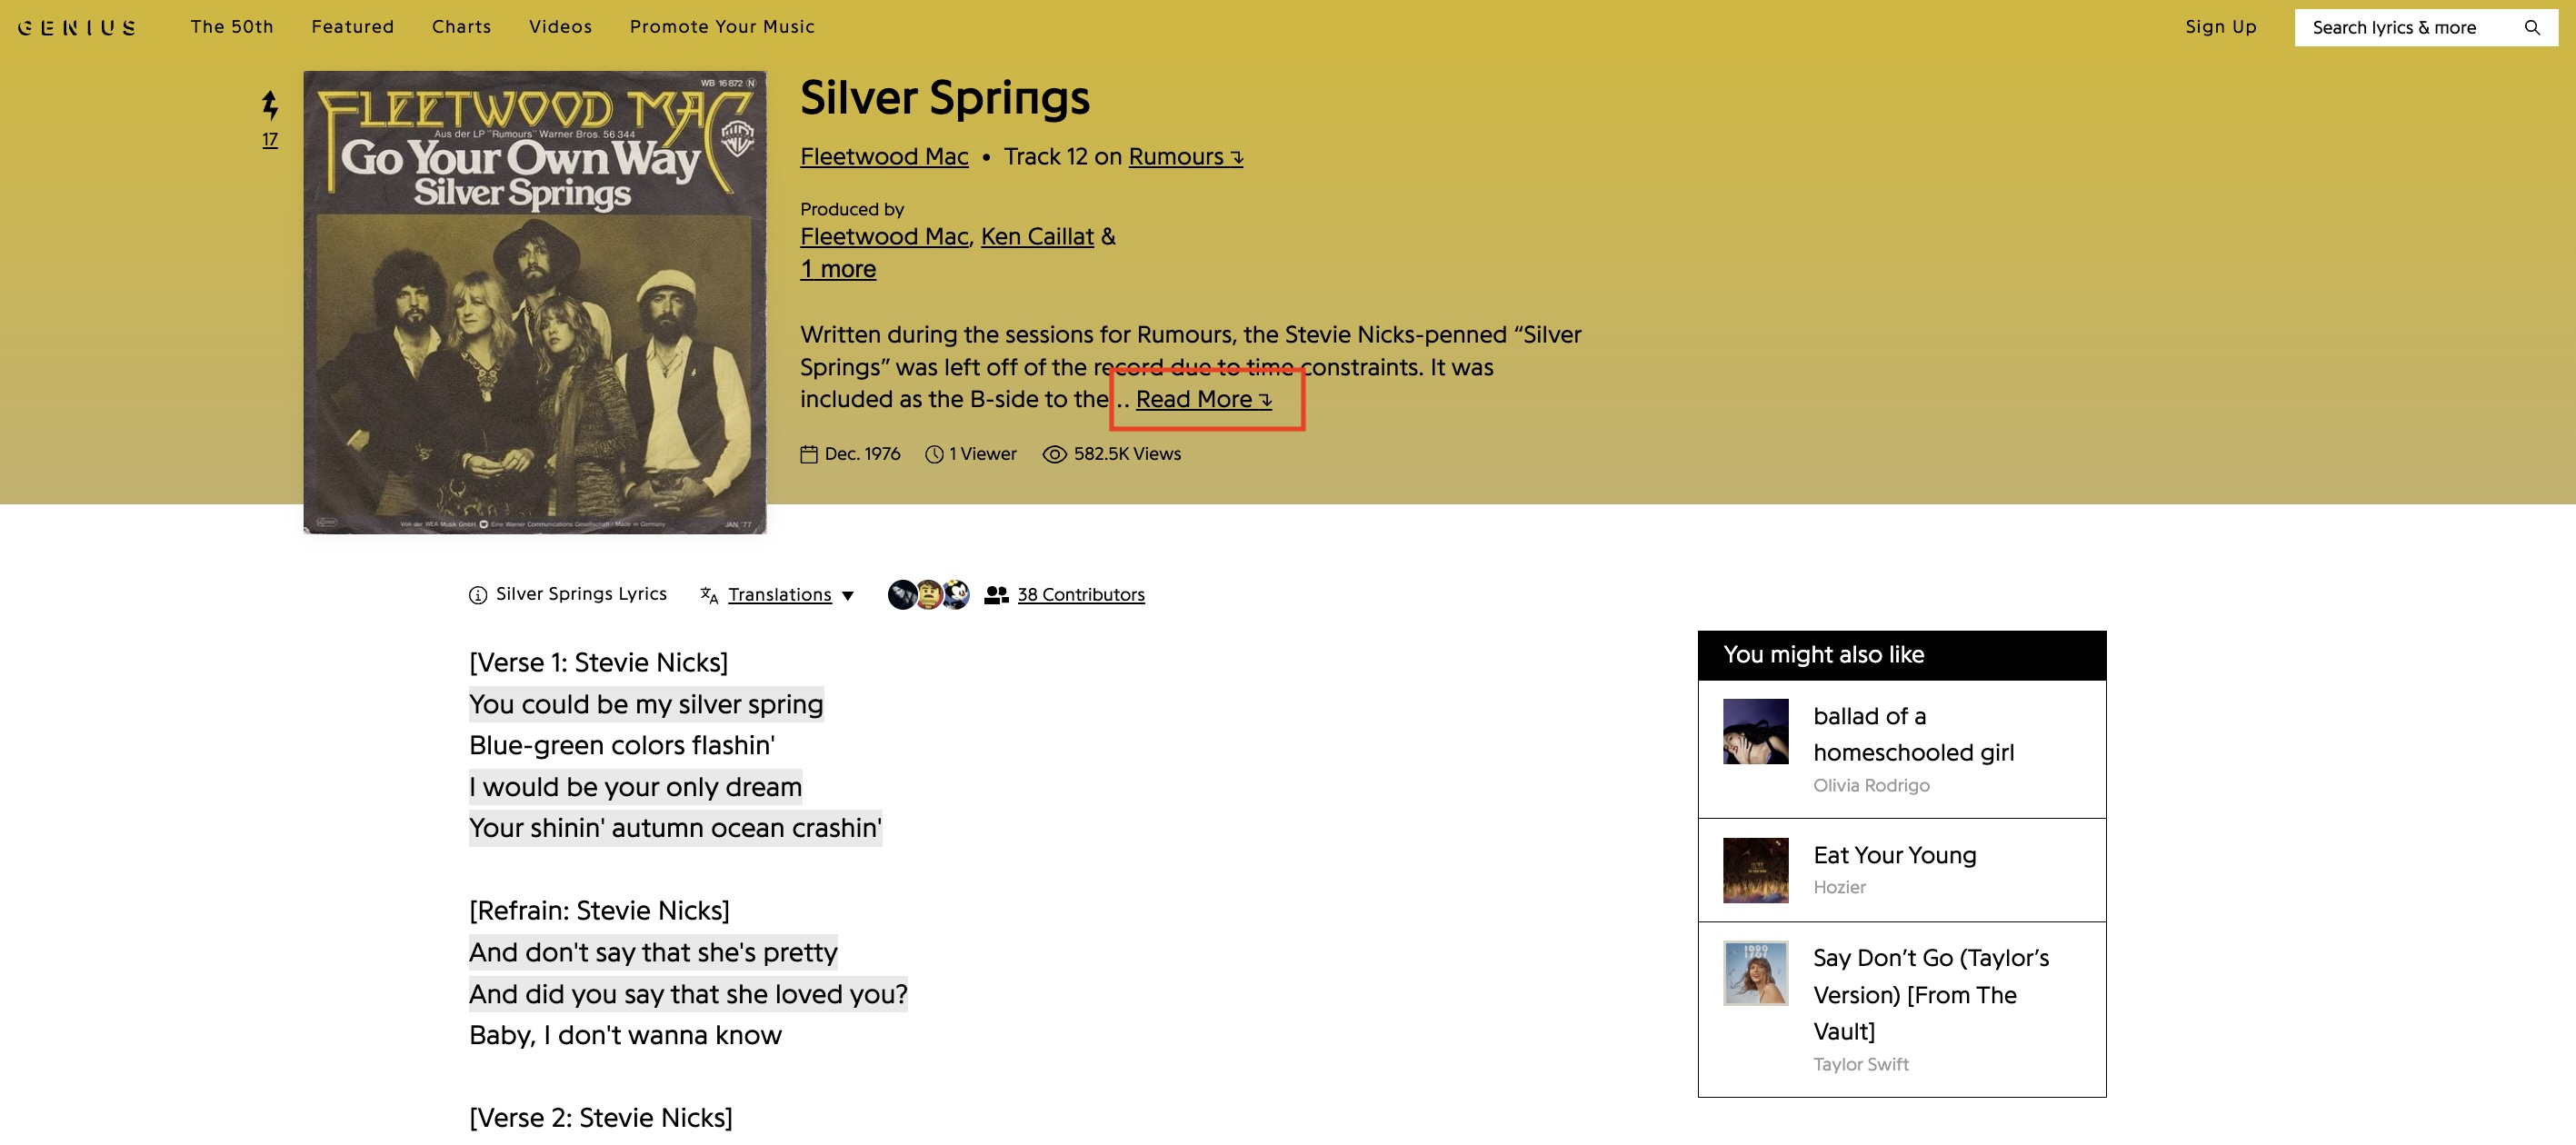

In [354]:
Image(filename='figs/genius-screenshot-1.jpg')

The whole dataset in the end was 9GB, which is pretty huge to load into memory. In order to save time and space, I loaded it in, did some preliminary cleaning, and then pickled it. It is too big to commit to Github, so we have provided it [here](https://drive.google.com/file/d/11P3akby_WB1TlNXtpMiShxvcFuqCmdJR/view?usp=sharing) (on Google Drive).

In [350]:
df = pd.read_pickle('data/genius/song_lyrics.pickle');

### Resources
We will make use of the following technologies to perform our analysis:

- Lemmatization in order to engineer informative features
- Latent Dirichlet Allocation (LDA) modeling in order to label each song with expressive topics
- K-Means and Singular Value Decomposition (SVD) to visualize our results

### Cleaning

We drop all songs that are missing data that we need to do our analysis. We also restrict our analysis to songs release in the years from 1970 to 2022, inclusive.

In [37]:
# drop all songs that are not country
df = df[df['tag'] == 'country']
print('dropped all songs that are not country')

# drop all songs that are not in english
df = df[df['language'] == 'en']
print('dropped all songs that are not in english')

# drop all songs with no lyrics
df = df[df['lyrics'].notnull()]
print('dropped all songs with no lyrics')

# drop all songs with no year
df = df[df['year'].notnull()]
print('dropped all songs with no year')

# drop all songs not in the range 1970-2022
df = df[df['year'] >= 1970]
df = df[df['year'] <= 2022]
print('dropped all songs not in the range 1970-2022')

dropped all songs that are not country
dropped all songs that are not in english
dropped all songs with no lyrics
dropped all songs with no year
dropped all songs not in the range 1970-2022


Something else that we want to address is the imbalance in the dataset. Below, we create a histogram of the number of songs in each year. We want to randomly sample our dataset so that each year has the same amount of songs. This is important for several reasons.
- In our predictive modeling problem, having too many samples from one year can lead the model to learn patterns that are specific to that year only, rather than learning more generalizable patterns.
- Our dataset has way more songs from the years 2015-2021, the model we train on the data will be biased towards phenomena present in these years.
- By ensuring that there are equal amounts of data per time period, we increase the generalizability of our results. This will be very important for generating lyrics later.

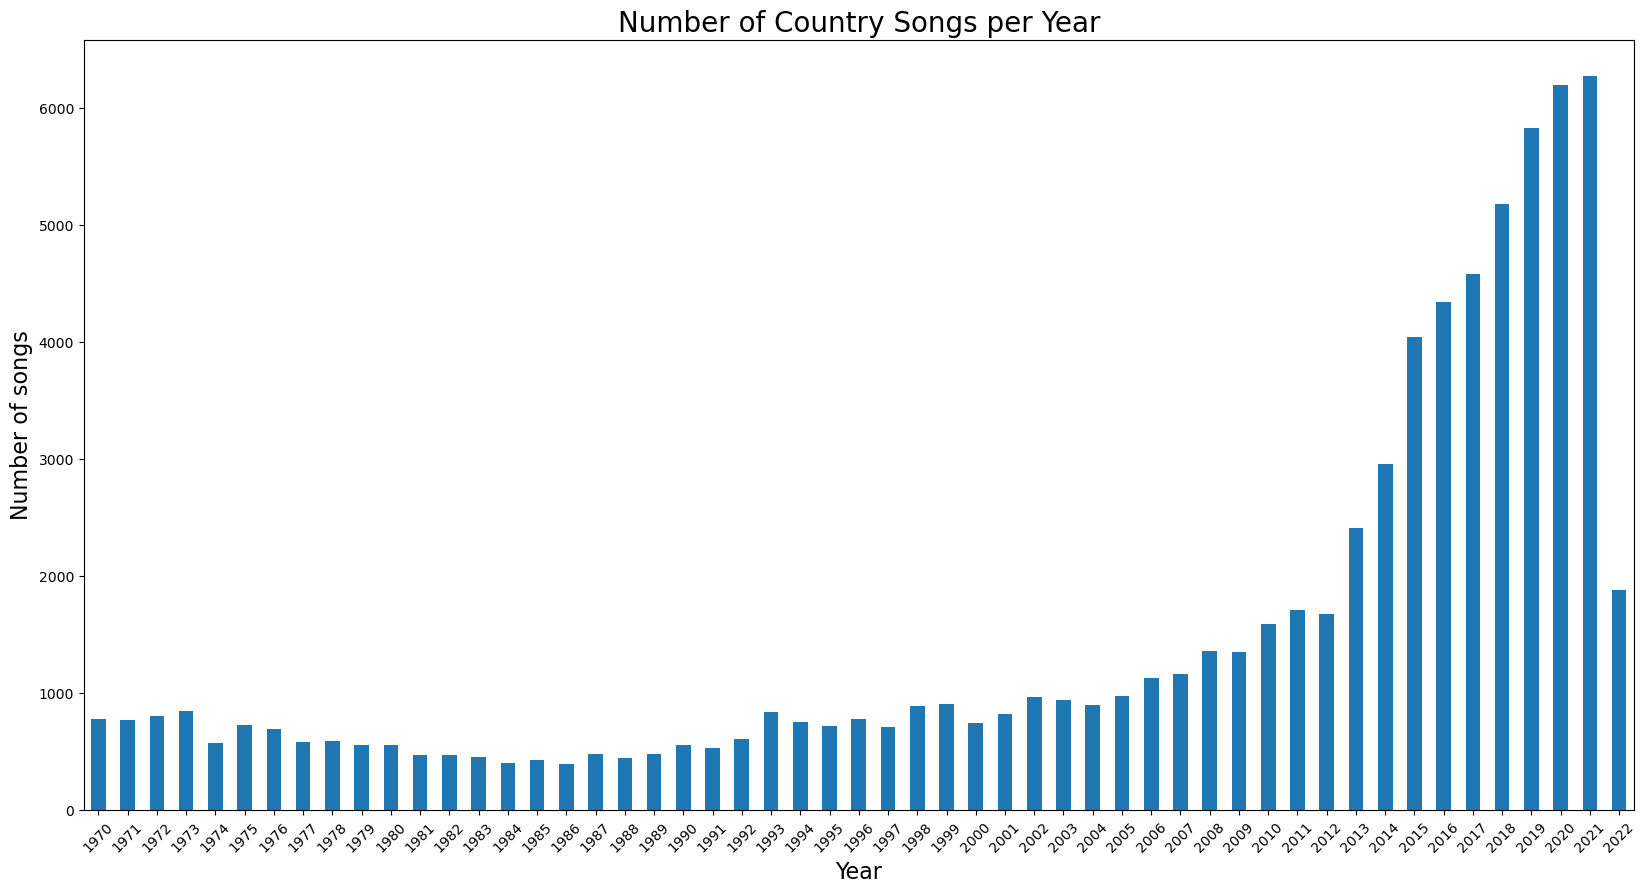

In [343]:
hist_by_year = df.groupby('year').count()['lyrics']

fig = plt.figure(figsize=(20, 10))
hist_by_year.plot.bar()
plt.title('Number of Country Songs per Year', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of songs', fontsize=16)
plt.xticks(rotation=45)
plt.savefig('figs/number_of_country_songs_per_year.png')
plt.show()

We decided to randomly sample 1,000 songs from each year with replacement. Below, we display two datasets:
- The fully cleaned original dataset.
- The fully cleaned, balanced dataset (via random sampling).

We aim to use both of these datasets in our analysis, potentially comparing the results in applying various techniques to each of them.

In [44]:
# randomly sample 1000 songs per year
balanced_df = df.groupby('year').apply(lambda x: x.sample(n=1000, random_state=42, replace=True)).reset_index(drop=True)
print('randomly sampled 30000 songs per year')

# drop unncessary columns
if 'features' in df.columns and 'language' in df.columns and 'id' in df.columns:
    df = df.drop(columns=['features', 'language', 'id'])
if 'features' in balanced_df.columns and 'language' in balanced_df.columns and 'id' in balanced_df.columns:
    balanced_df = balanced_df.drop(columns=['features', 'language', 'id'])
print('dropped unnecessary columns')

# sort
df = df.sort_values('year', ascending=True)
balanced_df = balanced_df.sort_values('year', ascending=True)
df = df.reset_index(drop=True)
balanced_df = balanced_df.reset_index(drop=True)
print('sorted')

randomly sampled 30000 songs per year
dropped unnecessary columns
sorted


In [58]:
df.head()

,title,tag,artist,year,views,lyrics
0,Southwind,country,Johnny Cash,1970,476,[Intro]\nSouthwind\n\n[Verse 1]\nYou picked he...
1,Another Mountain To Climb,country,Warner Mack,1970,88,[Chorus]\nI got another mountain to climb I go...
2,Come On Home And Sing The Blues To Daddy,country,Warner Mack,1970,13,[Verse 1]\nWell I hear that your new romance h...
3,Bright Lights Big City,country,Warner Mack,1970,6,[Verse 1]\nBright lights the big city has gone...
4,Im Living In Two Worlds,country,Warner Mack,1970,30,[Chorus]\nI'm living in two worlds dividing my...


In [57]:
assert len(balanced_df) == (2022-1970+1) * 1000
balanced_df.head()

,title,tag,artist,year,views,lyrics
0,He Darked the Sun,country,Linda Ronstadt,1970,564,"It was not so long ago, maybe just a year or s..."
1,Yukon Railroad,country,The Nitty Gritty Dirt Band,1970,117,"Here we go sailin' low\nBet your mom and papa,..."
2,Christmas And Love,country,Charley Pride,1970,597,I live in a three-room shack it's not much to ...
3,Each Season Changes You,country,Porter Wagoner & Dolly Parton,1970,754,[Chorus]\nLike the weather your heart changes ...
4,Youve Lost That Lovin Feelin,country,Elvis Presley,1970,6444,[Verse 1]\nYou never close your eyes\nAnymore ...


In [60]:
# save
df.to_pickle('data/country/song_lyrics_country.pickle')
balanced_df.to_pickle('data/genius-pickled-clean/song_lyrics_country_balanced.pickle')

In [ ]:
# load
df = pd.read_pickle('data/country/song_lyrics_country.pickle')
balanced_df = pd.read_pickle('data/country/song_lyrics_country_balanced.pickle')

### Exploration
On average, the length of country music songs increases over time.

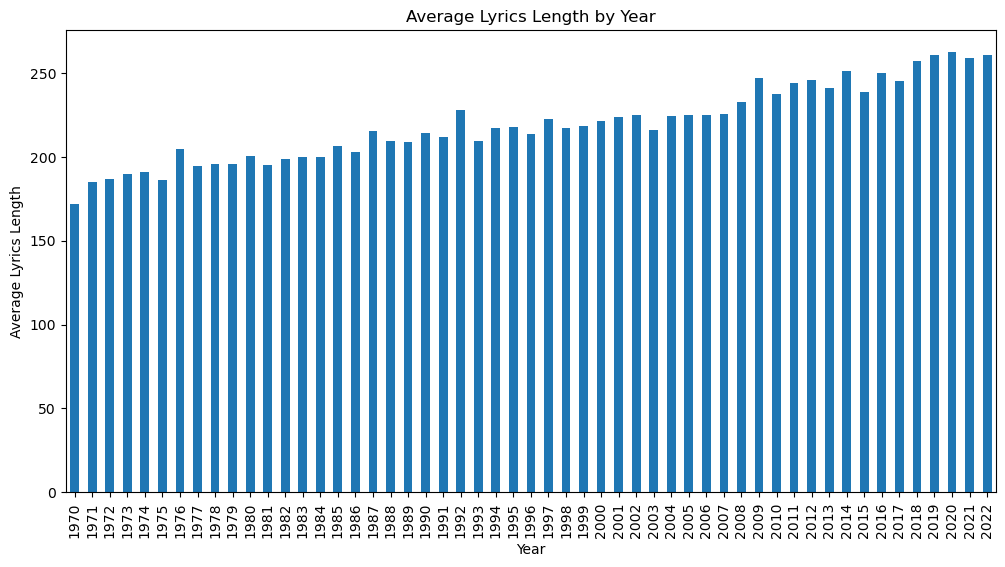

In [342]:
# simple tokenization: split on whitespace
lyrics_lengths = df['lyrics'].apply(lambda x: len(x.split()))
balanced_df['lyric length'] = balanced_df['lyrics'].apply(lambda x: len(x.split()))

average_lyrics_length = balanced_df.groupby('year')['lyric length'].mean()

plt.figure(figsize=(12, 6))
average_lyrics_length.plot(kind='bar')
plt.title('Average Lyrics Length by Year')
plt.xlabel('Year')
plt.ylabel('Average Lyrics Length')
plt.savefig('figs/average_lyrics_length_by_year.png')
plt.show()

### Feature Engineering

Let's take a look at what the lyrics entry of our dataset looks like.

In [106]:
example_lyrics = df['lyrics'][0]
print(example_lyrics)

[Intro]
Southwind

[Verse 1]
You picked her up in Jacksonville
And left me cold and lonesome in the rain
Southwind
You took her off to Nashville
Left me choking in the smoke behind the train
And you go whoooo-wooo-hoo
She's gone again on the Southwind

[Chorus]
Southwind

[Verse 2]
I need a forty-dollar ticket
And about this time tomorrow I'll be gone
Southwind
But if I had forty dollars
I would buy myself a smile to carry on
And you go whoooo-wooo-hoo
She's gone again on the Southwind
[Chorus]

[Verse 3]
Take her fast and take her far
Сause that's the way she always likes to go
Southwind
I will be waiting for the round trip
If you'll bring her back and I done told her so
Don't you go whoooo-wooo-hoo
She's gone again on the Southwind


We should remove all of the newline and whitespace characters (and replace them with ' '). Additionally, notice that the words in the square brackets ([Intro], [Verse 1], [Chorus], etc.) are not part of the lyrics but annotations that Genius includes to denote parts of the song. Let's remove these too. Finally, let's add the title of the song to the beginning of the lyrics.

In [107]:
# function to handle newlines and whitespace
def replace_unicode_escapes(text):
  text = text.replace('\u2005', ' ').replace('\u205f', ' ').replace('\u200a', ' ').replace('\n', ' ').replace(r'\\', ' ')
  pattern = r'\\u[0-9a-fA-F]{4}'
  text = text.replace('\\', '')
  return re.sub(pattern, ' ', text)

# function to remove text in brackets
def remove_text_in_brackets(text):
    return re.sub(r'\[.*?\]', ' ', text)

# apply functions
cleaned_lyrics = list(df['lyrics'].apply(replace_unicode_escapes))
cleaned_lyrics = list(map(remove_text_in_brackets, cleaned_lyrics))

df['text'] = df['title'] + cleaned_lyrics

Now, let's handle tokenization. We leverage `genism` here, removing punctuation so there's no issues with breaking up words like "I'm" and "You're," which are likely common lyrics.

In [115]:
texts = df['text'].tolist()

# tokenize
tokenized_texts = []
for index, text in enumerate(texts):
  tokenized_texts.append(gensim.utils.simple_preprocess(str(text), deacc=True))
  if index % 10000 == 0:  
    print('tokenized text ' + str(index))

print('tokenized all texts')

tokenized text 0
tokenized text 10000
tokenized text 20000
tokenized text 30000
tokenized text 40000
tokenized text 50000
tokenized text 60000
tokenized text 70000
tokenized all texts


['southwind', 'southwind', 'you', 'picked', 'her', 'up', 'in', 'jacksonville', 'and', 'left', 'me', 'cold', 'and', 'lonesome', 'in', 'the', 'rain', 'southwind', 'you', 'took', 'her', 'off', 'to', 'nashville', 'left', 'me', 'choking', 'in', 'the', 'smoke', 'behind', 'the', 'train', 'and', 'you', 'go', 'whoooo', 'wooo', 'hoo', 'she', 'gone', 'again', 'on', 'the', 'southwind', 'southwind', 'need', 'forty', 'dollar', 'ticket', 'and', 'about', 'this', 'time', 'tomorrow', 'll', 'be', 'gone', 'southwind', 'but', 'if', 'had', 'forty', 'dollars', 'would', 'buy', 'myself', 'smile', 'to', 'carry', 'on', 'and', 'you', 'go', 'whoooo', 'wooo', 'hoo', 'she', 'gone', 'again', 'on', 'the', 'southwind', 'take', 'her', 'fast', 'and', 'take', 'her', 'far', 'сause', 'that', 'the', 'way', 'she', 'always', 'likes', 'to', 'go', 'southwind', 'will', 'be', 'waiting', 'for', 'the', 'round', 'trip', 'if', 'you', 'll', 'bring', 'her', 'back', 'and', 'done', 'told', 'her', 'so', 'don', 'you', 'go', 'whoooo', 'wooo'

Now, we use lemmatization in order to improve our consistency. This will facilitate a better topic model for the lyrics dataset.

In [126]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# function to lemmatize into strings
def string_lemmatize(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  doc = nlp(" ".join(text)) 
  return " ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags])

# lemmatize
lemmatized_texts = []
for index, text in enumerate(tokenized_texts):
  lemmatized_texts.append(string_lemmatize(text))
  if index % 1000 == 0:
    print('lemmatized text ' + str(index))

lemmatized text 0
lemmatized text 1000
lemmatized text 2000
lemmatized text 3000
lemmatized text 4000
lemmatized text 5000
lemmatized text 6000
lemmatized text 7000
lemmatized text 8000
lemmatized text 9000
lemmatized text 10000
lemmatized text 11000
lemmatized text 12000
lemmatized text 13000
lemmatized text 14000
lemmatized text 15000
lemmatized text 16000
lemmatized text 17000
lemmatized text 18000
lemmatized text 19000
lemmatized text 20000
lemmatized text 21000
lemmatized text 22000
lemmatized text 23000
lemmatized text 24000
lemmatized text 25000
lemmatized text 26000
lemmatized text 27000
lemmatized text 28000
lemmatized text 29000
lemmatized text 30000
lemmatized text 31000
lemmatized text 32000
lemmatized text 33000
lemmatized text 34000
lemmatized text 35000
lemmatized text 36000
lemmatized text 37000
lemmatized text 38000
lemmatized text 39000
lemmatized text 40000
lemmatized text 41000
lemmatized text 42000
lemmatized text 43000
lemmatized text 44000
lemmatized text 45000
l

In [148]:
# function to lemmatize into lists
def list_lemmatization(lyrics, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for index, lyric in enumerate(lyrics):
        doc = nlp(" ".join(lyric)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        if index % 1000 == 0:
            print('progress: ' + str(index) + '/' + str(len(lyrics)))
    return texts_out

# lemmatize
list_lemmatized_texts = list_lemmatization(tokenized_texts)

# save
with open('data/country/list_lemmatized_texts.pickle', 'wb') as f:
    pickle.dump(list_lemmatized_texts, f)

# create dictionary
id2word = gensim.corpora.Dictionary(list_lemmatized_texts)

progress: 0/77633
progress: 1000/77633
progress: 2000/77633
progress: 3000/77633
progress: 4000/77633
progress: 5000/77633
progress: 6000/77633
progress: 7000/77633
progress: 8000/77633
progress: 9000/77633
progress: 10000/77633
progress: 11000/77633
progress: 12000/77633
progress: 13000/77633
progress: 14000/77633
progress: 15000/77633
progress: 16000/77633
progress: 17000/77633
progress: 18000/77633
progress: 19000/77633
progress: 20000/77633
progress: 21000/77633
progress: 22000/77633
progress: 23000/77633
progress: 24000/77633
progress: 25000/77633
progress: 26000/77633
progress: 27000/77633
progress: 28000/77633
progress: 29000/77633
progress: 30000/77633
progress: 31000/77633
progress: 32000/77633
progress: 33000/77633
progress: 34000/77633
progress: 35000/77633
progress: 36000/77633
progress: 37000/77633
progress: 38000/77633
progress: 39000/77633
progress: 40000/77633
progress: 41000/77633
progress: 42000/77633
progress: 43000/77633
progress: 44000/77633
progress: 45000/77633
p

Finally, we vectorize the texts using a `CountVectorizer`. Here, we use fairly conventional arguments, including setting `stop_words='english'` to exclude these words (which are likely extremely common in song lyrics) from our vectors. Additionally, we set the minimum document frequency to 10, since we want relatively unique words. The token pattern setting restricts us to alphanumeric words with 3 or more characters. We also set the maximum number of features to 50000, since topic modeling is pretty computationally expensive.

In [167]:
vectorizer = CountVectorizer(analyzer='word', min_df=10, stop_words='english', lowercase=True, token_pattern='[a-zA-Z0-9]{3,}', max_features=50000)
vectorized_texts = vectorizer.fit_transform(lemmatized_texts)

### Topic Modeling
As we mentioned earlier, we make use of [LDA](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) in order to model a topic distribution over the dataset of lyrics. Here, we initialize the model with 10 topics, a decision that we hope will make our topics uniqiue from one another. We also use the Online Variational Bayes Method (paper [here](https://www.di.ens.fr/~fbach/mdhnips2010.pdf)) to speed up computation.

In [163]:
# LDA
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', random_state=42, batch_size=256)
lda_output = lda_model.fit_transform(vectorized_texts)
print(lda_model)

LatentDirichletAllocation(batch_size=256, learning_method='online',
                          random_state=42)


Let's take a look at what these topics actually are. It is integral that our topics are expressive.

In [166]:
# show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)

# topic key words df
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word ' + str(i + 1) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic ' + str(i + 1) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,love,heart,baby,want,hold,make,fall,know,need,kiss
Topic 2,time,let,good,make,just,life,right,thing,know,way
Topic 3,come,soul,hear,angel,bring,lie,rise,sing,child,pray
Topic 4,boy,fight,blood,gun,dead,war,shoot,welcome,great,make
Topic 5,know,say,just,tell,think,leave,want,way,try,look
Topic 6,man,home,old,run,say,ride,hand,woman,die,river
Topic 7,away,day,night,light,leave,blue,just,eye,come,rain
Topic 8,come,work,people,money,time,year,hard,wait,day,new
Topic 9,song,country,roll,road,town,night,play,sing,rock,old
Topic 10,ain,little,girl,just,drink,good,boy,baby,right,beer


We use 3 metrics to evaluate our model:
- **Log Likelihood:** The log likelihood refers to the logarithm of the probability of observing the given data (for us, the dataset of songs) under the assumptions of the LDA model. LDA is a generative probabilistic model that assumes each document is a mixture of various topics, and each topic is a distribution over words.
- **Perplexity:** Perplexity, as defined in the LDA paper, is
\begin{align*}
  \text{Perplexity} = e^{-\text{Log Likelihood per Word}}
\end{align*}
and provides a measure of how well the model captures the characteristics of the text.
- **Coherence:** Coherence scores help to evaluate how semantically meaningful the topics are. Cohere is based on the degree of semantic similarity between high scoring words within each topic.
  - Here, we use the $C_v$ measure, which is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and cosine similarity.

In [164]:
print("Log Likelihood: ", lda_model.score(vectorized_texts))
print("Perplexity: ", lda_model.perplexity(vectorized_texts))
print(lda_model.get_params())

Log Likelihood:  -43879763.61668775
Perplexity:  909.5623238921779
{'batch_size': 256, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [165]:
# get feature names
feature_names = vectorizer.get_feature_names_out()

# sklearn doesn't have a built-in coherence metric, so we use gensim
dictionary = Dictionary([vectorizer.get_feature_names_out()])

# BoW corpus
corpus = Sparse2Corpus(vectorized_texts, documents_columns=False)

# get topics from LDA model
lda_topics = []
for topic_idx, topic in enumerate(lda_model.components_):
    # sort words by weight (highest to lowest)
    sorted_words = topic.argsort()[::-1]
    # get 10 words
    topic_words = [feature_names[i] for i in sorted_words[:10]]
    lda_topics.append(topic_words)

# compute coherence score
coherence_model_lda = CoherenceModel(topics=lda_topics, texts=list_lemmatized_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.45044688019511303


Now, how do we use these metrics to actually optimize our model? It's important to consider the meaning of each of these metrics in the context of our problem. Our question is rooted in a qualitative question: how do the ideas expressed in country music change from 1970 to 2022? Because of this, we care more about interpretability than statistical significance, and this leads us to optimize for high coherence as opposed to low log likelihood or low perplexity.

High coherence scores in LDA indicate that the topics generated by the model are more interpretable and meaningful. Since our study aims to identify and understand the thematic shifts in lyrics, it's crucial that the topics generated are not just statistically significant, but also thematically relevant and easily understandable. This allows for a more accurate and insightful exploration of how themes have evolved from traditional to contemporary issues.

In [180]:
param_grid = {
    'n_components': [5, 7, 10], # number of topics [5, 7, 10]
    'learning_decay': [0.5, 0.7, 0.9], # learning rate (0.5, 0.7, 0.9)
    'doc_topic_prior': [0.1, 0.5, 0.9], # alpha (0.1, 0.5, 0.9)
    'topic_word_prior': [0.1, 0.5, 0.9] # eta (0.1, 0.5, 0.9)
}

# lda model with online learning, max 10 iterations
lda = LatentDirichletAllocation(max_iter=10, learning_method='online', random_state=42, batch_size=256)

# get feature names
feature_names = vectorizer.get_feature_names_out()

# sklearn doesn't have a built-in coherence metric, so we use gensim
dictionary = Dictionary([vectorizer.get_feature_names_out()])

# BoW corpus
corpus = Sparse2Corpus(vectorized_texts, documents_columns=False)

# define custom scorer
def coherence_scorer(estimator, X):
    # get topic word distribution
    topic_word_distribution = estimator.components_ / estimator.components_.sum(axis=1)[:, np.newaxis]
    
    lda_topics = []
    for topic_idx, topic in enumerate(estimator.components_):
        # sort words by weight (highest to lowest)
        sorted_words = topic.argsort()[::-1]
        # get 10 words
        topic_words = [feature_names[i] for i in sorted_words[:10]]
        lda_topics.append(topic_words)
    
    # Compute and return the coherence score
    coherence_model = CoherenceModel(topics=lda_topics, texts=list_lemmatized_texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# grid search with custom scorer above
grid_search = GridSearchCV(lda, param_grid, scoring=coherence_scorer, cv=2, verbose=3, pre_dispatch='2*n_jobs')

# search the parameter space
grid_search.fit(vectorized_texts)

# evaluate best model
best_lda_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_coherence_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Coherence Score:", best_coherence_score)

Fitting 2 folds for each of 81 candidates, totalling 162 fits
[CV 1/2] END doc_topic_prior=0.1, learning_decay=0.5, n_components=5, topic_word_prior=0.1;, score=0.460 total time= 1.1min
[CV 2/2] END doc_topic_prior=0.1, learning_decay=0.5, n_components=5, topic_word_prior=0.1;, score=0.433 total time= 1.0min
[CV 1/2] END doc_topic_prior=0.1, learning_decay=0.5, n_components=5, topic_word_prior=0.5;, score=0.453 total time= 1.3min
[CV 2/2] END doc_topic_prior=0.1, learning_decay=0.5, n_components=5, topic_word_prior=0.5;, score=0.433 total time= 1.2min
[CV 1/2] END doc_topic_prior=0.1, learning_decay=0.5, n_components=5, topic_word_prior=0.9;, score=0.451 total time= 1.4min
[CV 2/2] END doc_topic_prior=0.1, learning_decay=0.5, n_components=5, topic_word_prior=0.9;, score=0.430 total time= 1.3min
[CV 1/2] END doc_topic_prior=0.1, learning_decay=0.5, n_components=7, topic_word_prior=0.1;, score=0.448 total time= 1.3min
[CV 2/2] END doc_topic_prior=0.1, learning_decay=0.5, n_components=7, 

In [352]:
print("Best Log Likelihood: ", best_lda_model.score(vectorized_texts))
print("Best Perplexity: ", best_lda_model.perplexity(vectorized_texts))
print('Best LDA Model:')
print(lda_model.get_params())

Best Log Likelihood:  -43652171.49902791
Best Perplexity:  877.9824247056603
Best LDA Model:
{'batch_size': 256, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


Let's take a look at what the key words are for our topics. These topics are expressive, in our opinion. This is an assessment that is reinforced by the high coherence score achieved using the grid search above.

In [186]:
best_topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=10)

# topic key words df
df_topic_keywords = pd.DataFrame(best_topic_keywords)
df_topic_keywords.columns = ['Word ' + str(i + 1) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic ' + str(i + 1) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,love,baby,let,want,know,girl,need,make,heart,feel
Topic 2,time,good,life,way,day,make,just,know,live,thing
Topic 3,come,soul,man,die,hand,home,stand,bear,angel,child
Topic 4,fuck,shit,gun,bitch,kill,make,shoot,need,boy,want
Topic 5,know,just,say,think,tell,leave,heart,time,break,cause
Topic 6,road,home,ride,town,run,country,roll,old,drive,way
Topic 7,light,night,sky,away,come,rain,sun,day,blue,dream
Topic 8,man,say,old,little,boy,make,girl,just,look,big
Topic 9,song,sing,play,dance,hear,music,country,rock,singe,guitar
Topic 10,ain,little,just,girl,night,drink,right,good,baby,come


Now, let's see if we can come up with more general ideas that encapsulate the main idea of each topic. Below, we provide a justification for each label:
- Topic 1: Love/Women — the words centered around this topic largely have to do with women and love, like "baby", "girl", "need", all center around this topic area, so we decided to define it as such
- Topic 2: Everyday Life — this topic contains fairly ordinary words, like "day", "life", "live", "way", and "time" which comprise relatively ordinary words in the context of everyday life
- Topic 3: Faith/Religion — key words in this topic like "angel", "soul", "man", and "die" are emblematic of religious values and teachings
- Topic 4: Violence — this topic contains various curse words and violent words like "gun" making this interpretation straightforward 
- Topic 5: Heartbreak — with words like "leave", "break", "cause", and "heart" we deemed this topic to center around heartbreak 
- Topic 6: Driving — largely centered around driving contextual words, like "road", "ride", "home", and "drive" these words seemed to concern with driving topics in a song
- Topic 7: Nature — words like "sky", "rain", "sun", and "night" are all nature themed when grouped together
- Topic 8: Growth/Change — "little", "boy", "old", "man", "say", "look", and "big" when viewed together seem to represent growth in life and relative change 
- Topic 9: Music/Singing/Dancing — "song", "sing", "play", and "music" when grouped together clearly point to music singing and dancing
- Topic 10: Nightlife/Social — "night", "drink", "baby", "come" seem to be centered around central themes of nightlife and social interaction 

In [205]:
# topic names
index_to_topic = dict(enumerate(['Love/Women', 'Everyday Life', 'Faith/Religion', 'Violence', 'Heartbreak', 'Driving', 'Nature', 'Growth/Change', 'Music/Singing/Dancing', 'Nightlife/Social']))
df_topic_keywords.index = index_to_topic.values()
df_topic_keywords

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Love/Women,love,baby,let,want,know,girl,need,make,heart,feel
Everyday Life,time,good,life,way,day,make,just,know,live,thing
Faith/Religion,come,soul,man,die,hand,home,stand,bear,angel,child
Violence,fuck,shit,gun,bitch,kill,make,shoot,need,boy,want
Heartbreak,know,just,say,think,tell,leave,heart,time,break,cause
Driving,road,home,ride,town,run,country,roll,old,drive,way
Nature,light,night,sky,away,come,rain,sun,day,blue,dream
Growth/Change,man,say,old,little,boy,make,girl,just,look,big
Music/Singing/Dancing,song,sing,play,dance,hear,music,country,rock,singe,guitar
Nightlife/Social,ain,little,just,girl,night,drink,right,good,baby,come


Now, we compute the weights of each of these topics for each song in our dataset.

In [207]:
# apply model
lda_output = best_lda_model.transform(vectorized_texts)

# index
song_numbers = range(vectorized_texts.shape[0])

# df
df_document_topic = pd.DataFrame(np.round(lda_output, 3), columns=index_to_topic.values(), index=song_numbers)

# get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant topic'] = dominant_topic

# styling
def color_green(val):
  color = 'green' if val > .1 else 'black'
  return 'color: {col}'.format(col=color)
 
def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)

# apply style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Love/Women,Everyday Life,Faith/Religion,Violence,Heartbreak,Driving,Nature,Growth/Change,Music/Singing/Dancing,Nightlife/Social,dominant topic
0,0.004000,0.004000,0.004000,0.004000,0.258000,0.311000,0.210000,0.200000,0.004000,0.004000,5
1,0.048000,0.256000,0.001000,0.001000,0.339000,0.297000,0.051000,0.001000,0.001000,0.001000,4
2,0.001000,0.180000,0.025000,0.001000,0.162000,0.001000,0.001000,0.471000,0.156000,0.001000,7
3,0.278000,0.001000,0.001000,0.001000,0.200000,0.001000,0.287000,0.227000,0.001000,0.001000,6
4,0.002000,0.839000,0.002000,0.002000,0.002000,0.002000,0.144000,0.002000,0.002000,0.002000,1
5,0.463000,0.079000,0.002000,0.002000,0.077000,0.002000,0.002000,0.297000,0.002000,0.075000,0
6,0.103000,0.346000,0.004000,0.107000,0.348000,0.004000,0.075000,0.004000,0.004000,0.004000,4
7,0.001000,0.640000,0.034000,0.030000,0.197000,0.001000,0.093000,0.001000,0.001000,0.001000,1
8,0.407000,0.053000,0.001000,0.251000,0.055000,0.096000,0.130000,0.001000,0.001000,0.001000,0
9,0.003000,0.226000,0.003000,0.304000,0.003000,0.003000,0.003000,0.148000,0.303000,0.003000,3


Now, let's add these LDA topic weights to our original dataset so that we can put together an analysis of how the prevalance of each of these topics changes over time.

In [211]:
# copy df
df_with_topics = df.copy()

# concatenate topic distribution columns
df_with_topics = pd.concat([df_with_topics, df_document_topic], axis=1)

df_with_topics

,title,tag,artist,year,views,lyrics,lyrics length,text,Love/Women,Everyday Life,Faith/Religion,Violence,Heartbreak,Driving,Nature,Growth/Change,Music/Singing/Dancing,Nightlife/Social,dominant topic
0,Southwind,country,Johnny Cash,1970,476,[Intro]\nSouthwind\n\n[Verse 1]\nYou picked he...,137,Southwind Southwind You picked her up in J...,0.004,0.004,0.004,0.004,0.258,0.311,0.210,0.200,0.004,0.004,5
1,Another Mountain To Climb,country,Warner Mack,1970,88,[Chorus]\nI got another mountain to climb I go...,216,Another Mountain To Climb I got another mount...,0.048,0.256,0.001,0.001,0.339,0.297,0.051,0.001,0.001,0.001,4
2,Come On Home And Sing The Blues To Daddy,country,Warner Mack,1970,13,[Verse 1]\nWell I hear that your new romance h...,186,Come On Home And Sing The Blues To Daddy Well...,0.001,0.180,0.025,0.001,0.162,0.001,0.001,0.471,0.156,0.001,7
3,Bright Lights Big City,country,Warner Mack,1970,6,[Verse 1]\nBright lights the big city has gone...,159,Bright Lights Big City Bright lights the big ...,0.278,0.001,0.001,0.001,0.200,0.001,0.287,0.227,0.001,0.001,6
4,Im Living In Two Worlds,country,Warner Mack,1970,30,[Chorus]\nI'm living in two worlds dividing my...,132,Im Living In Two Worlds I'm living in two wor...,0.002,0.839,0.002,0.002,0.002,0.002,0.144,0.002,0.002,0.002,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77628,Plans of Salvation,country,Asakhe Nojoko,2022,4,Plans of Salvation begin to unfold in me\nNow ...,158,Plans of SalvationPlans of Salvation begin to ...,0.052,0.001,0.569,0.103,0.268,0.001,0.001,0.001,0.001,0.001,2
77629,If You Want It That Much,country,Cody Canada and the Departed,2022,48,"[Verse 1]\nI wrote you a letter, I called on t...",253,If You Want It That Much I wrote you a letter...,0.052,0.001,0.047,0.046,0.268,0.001,0.379,0.001,0.037,0.169,6
77630,Every Saturday Night,country,Vandoliers,2022,38,[Chorus]\nI took for granted every Saturday ni...,343,Every Saturday Night I took for granted every...,0.088,0.281,0.001,0.001,0.037,0.001,0.114,0.001,0.105,0.372,9
77631,Plain Jane,country,Hailey Whitters,2022,306,[Verse 1]\nI like my drinks a little too stron...,344,Plain Jane I like my drinks a little too stro...,0.029,0.053,0.052,0.001,0.167,0.036,0.001,0.484,0.009,0.170,7


There are two ways that we can aggreagate this data by year. These are shown below.

### Data Aggregation Method 1
Next, we aggregate the number of songs that are *primarily* about each topic per year.

In [215]:
# topic counts by year
topic_counts_by_year = df_with_topics.groupby('year')['dominant topic'].value_counts().unstack().fillna(0)

# normalize
topic_counts_by_year = topic_counts_by_year.div(topic_counts_by_year.sum(axis=1), axis=0)
topic_counts_by_year.head()

dominant topic,0,1,2,3,4,5,6,7,8,9
year,,,,,,,,,,
1970,0.133420,0.159326,0.082902,0.007772,0.256477,0.046632,0.116580,0.150259,0.019430,0.027202
1971,0.111979,0.165365,0.113281,0.006510,0.244792,0.054688,0.134115,0.123698,0.022135,0.023438
1972,0.106650,0.159348,0.143036,0.010038,0.218319,0.045169,0.126725,0.122961,0.040151,0.027604
1973,0.115202,0.156770,0.100950,0.016627,0.211401,0.070071,0.125891,0.154394,0.029691,0.019002
1974,0.139373,0.142857,0.067944,0.008711,0.259582,0.069686,0.097561,0.142857,0.034843,0.036585


Let's plot these topics over time now.

<Figure size 2000x1000 with 0 Axes>

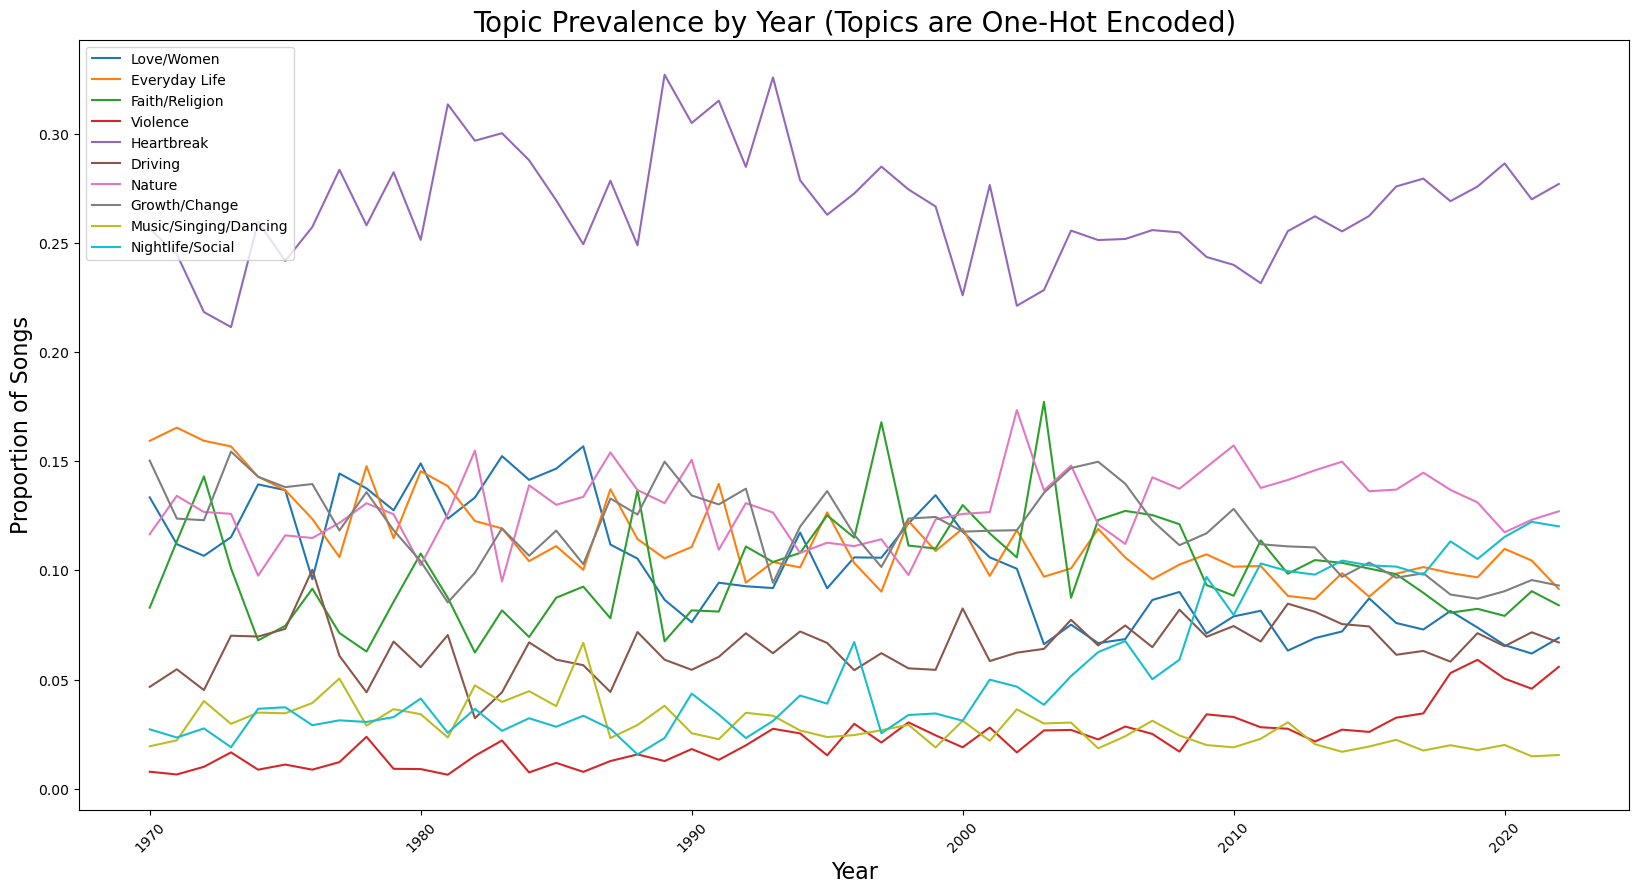

In [341]:
# plot the prevalence of each topic over time
fig = plt.figure(figsize=(20, 10))
topic_counts_by_year.plot.line(figsize=(20, 10))
plt.title('Topic Prevalence by Year (Topics are One-Hot Encoded)', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Proportion of Songs', fontsize=16)
plt.xticks(rotation=45)
plt.legend(topic_names)
plt.savefig('figs/topic_prevalence_by_year.png')
plt.show()

### Data Aggregation Method 2
We can also just compute the mean weight for each topic within each year.

<Figure size 2000x1000 with 0 Axes>

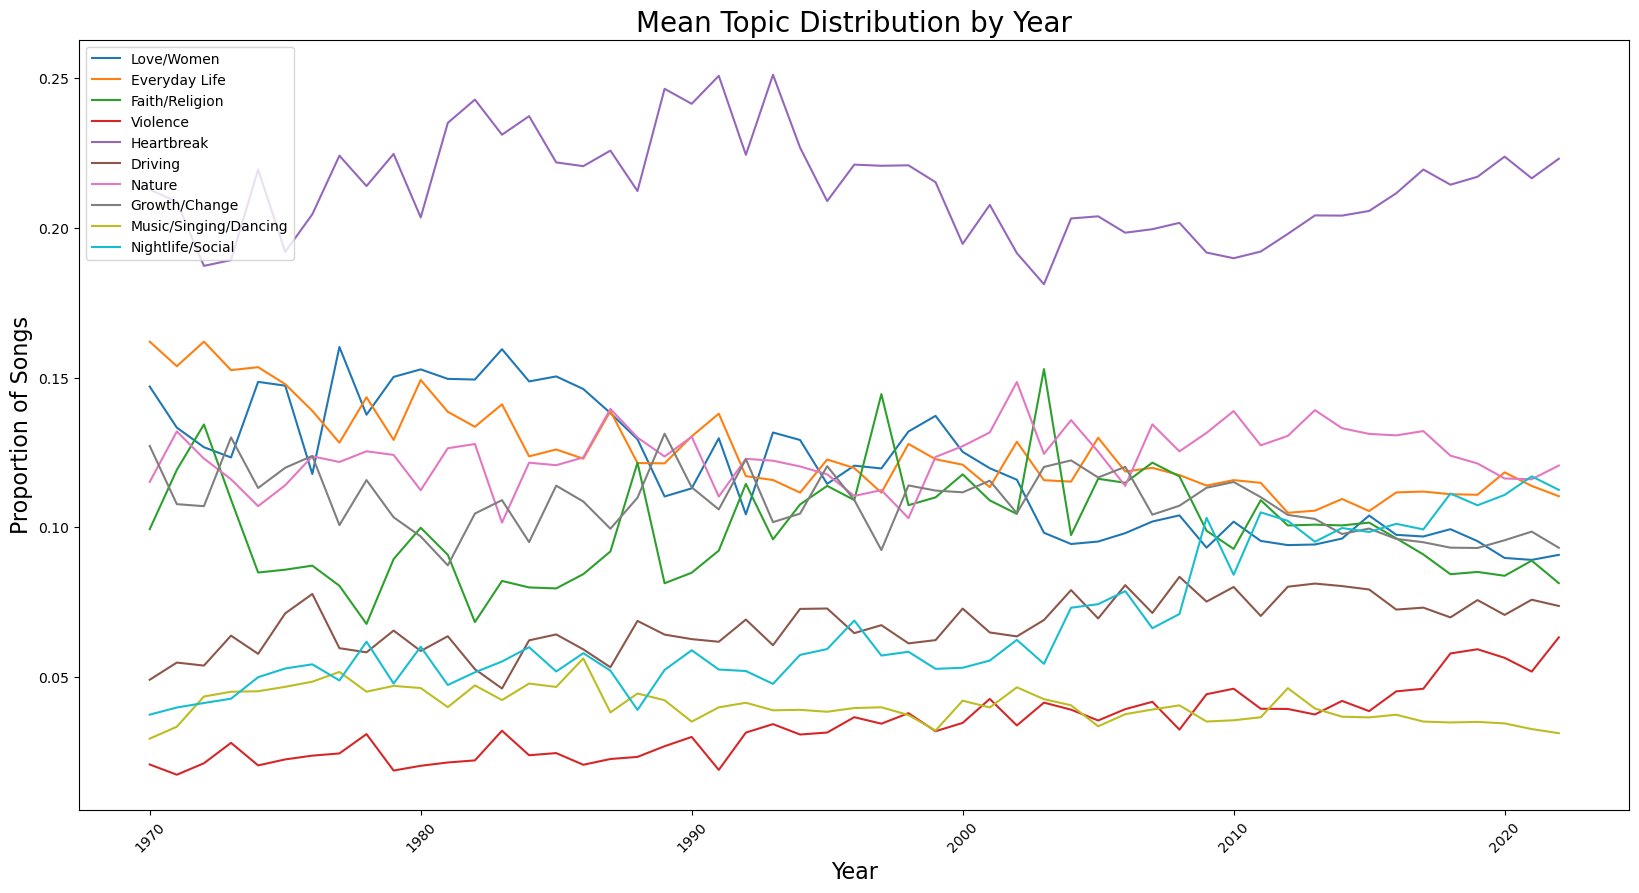

In [344]:
# mean topic distribution by year
mean_topic_distribution_by_year = df_with_topics.groupby('year')[topic_names].mean()

# plot the mean topic distribution over time
fig = plt.figure(figsize=(20, 10))
mean_topic_distribution_by_year.plot.line(figsize=(20, 10))
plt.title('Mean Topic Distribution by Year', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Proportion of Songs', fontsize=16)
plt.xticks(rotation=45)
plt.legend(topic_names)
plt.savefig('figs/mean_topic_distribution_by_year.png')
plt.show()

## 3. Results

### Topic Visualizations
Let's visualize some of the topic weights for some popular songs.

In [308]:
# find popular songs
# df_popularity_sorted = df_with_topics.sort_values('views', ascending=False)
# df_popularity_sorted.head(30)

In [345]:
# function to visualize topic modelling results for a given list of songs
def visualize_topic_modeling_results_multiple(song_indices):
  fig, axs = plt.subplots(1, len(song_indices), figsize=(6 * len(song_indices), 6), subplot_kw=dict(polar=True))
  fig.subplots_adjust(wspace=0.5)
  for index, song_index in enumerate(song_indices):
    # get song
    song = df_with_topics.iloc[song_index]

    # get lyrics
    lyrics = song['lyrics']

    # get topic distribution
    topic_distribution = song[topic_names].values

    # get dominant topic
    dominant_topic = song['dominant topic']

    # get topic name
    topic_name = index_to_topic[dominant_topic]

    # get topic keywords
    topic_keywords = topic_names[dominant_topic]

    # get topic keywords
    topic_keywords = df_topic_keywords.iloc[dominant_topic].values

    # get topic keywords
    topic_keywords = [keyword for keyword in topic_keywords if keyword != '']
    
    # get topic keywords
    topic_keywords = ', '.join(topic_keywords)

    angles = np.linspace(0, 2*np.pi, 10, endpoint=False).tolist()
    stats = np.concatenate((topic_distribution,[topic_distribution[0]]))
    angles += angles[:1]

    axs[index].fill(angles, stats, color='red', alpha=0.25)
    axs[index].plot(angles, stats, color='red', linewidth=2)
    axs[index].title.set_text('Topic Distribution for ' + song['title'] + ' by ' + song['artist'] + '\n(' + str(song['year']) + ')')
    axs[index].set_yticklabels([])
    axs[index].set_xticks(angles[:-1])
    axs[index].set_xticklabels(topic_names, fontsize=8)

    axs[index].spines['polar'].set_visible(False)
  plt.savefig('figs/topic_distribution_for_example_songs.png')
  plt.show()

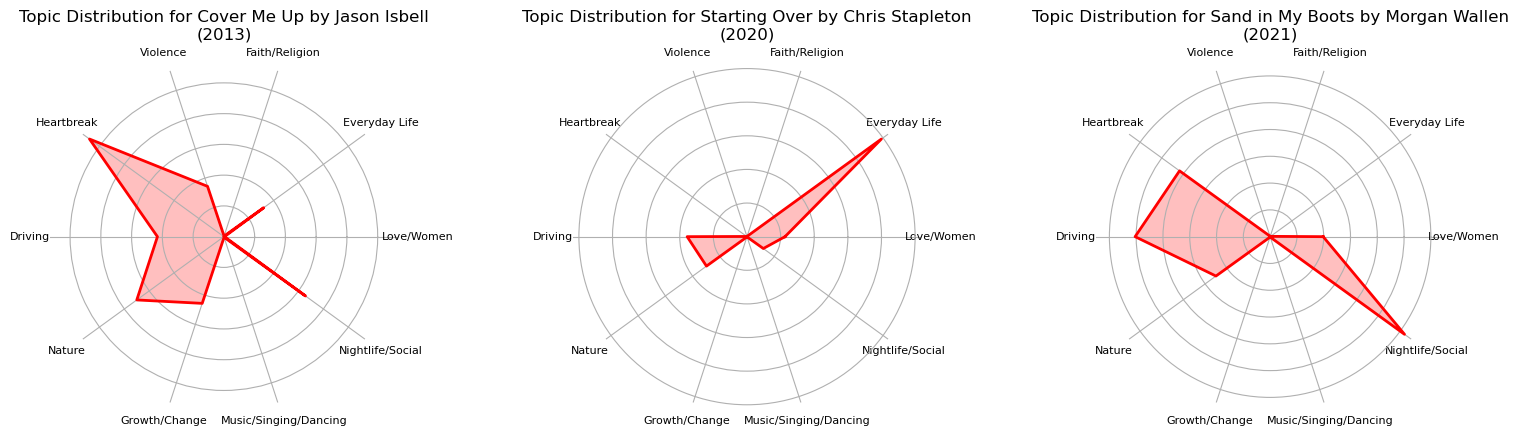

In [346]:
# cover me up, starting over, and sand in my boots
visualize_topic_modeling_results_multiple([35646, 67772, 73780])

### SVD Visualization
We can use K-means on the output of the LDA model (which is a matrix of probabilities for each song), and then visualize using SVD

/Users/cjkuk/miniconda3/envs/3350/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Component's weights: 
 [[ 0.281  0.301  0.213  0.086  0.75   0.147  0.307  0.229  0.077  0.202]
 [-0.095 -0.229 -0.393 -0.062  0.616 -0.194 -0.53  -0.258 -0.069 -0.105]]
Percentage of Variance Explained: 
 [0.064 0.194]


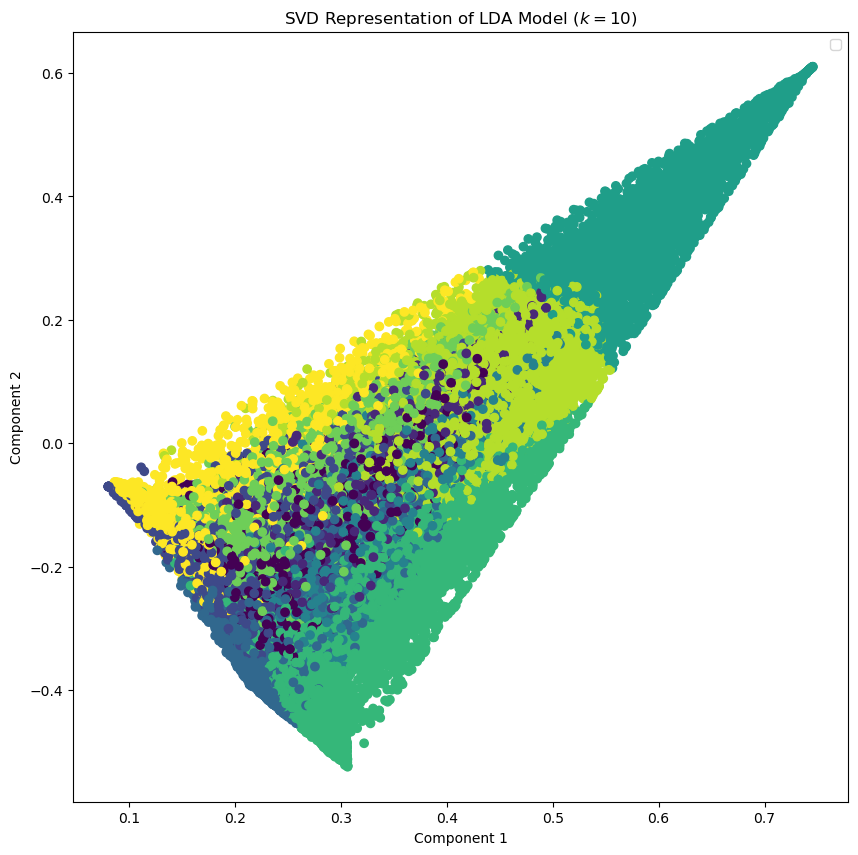

In [348]:
clusters = KMeans(n_clusters=10, random_state=42).fit_predict(lda_output)

# SVD model (2 components so we can plot in 2D)
svd = TruncatedSVD(n_components=2)
lda_output_svd = svd.fit_transform(lda_output)

# components
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# weights for each component
print("Component's weights: \n", np.round(svd.components_, 3))

# proportion of info in 'lda_output' explained by the two components
print("Percentage of Variance Explained: \n", np.round(svd.explained_variance_ratio_, 3))

# plot
plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('SVD Representation of LDA Model ($k=10$)')
plt.legend()
plt.savefig('figs/svd_representation_of_lda_model.png')
plt.show()

Looking at this visualization, each point represents a song with the corresponding color of each point being one of the topics. These colors are assigned to each song using a K-Means clustering algorithm, with 10 different topics identified amongst all the different songs. It is worth noting that the values of component 1 are strictly positive, while the values of component 2 are both positive and negative. The triangular shape is also interesting.

This visual summary can shows us more about the distribution of our data and similarity of the songs in our study with relation to topics, however there are limitations with this model. Since we are passing an LDA model through an additional K-Means algorithm, this creates interference when jumping from algorithm to algorithm.

### PyLDAvis

This library allows us to visualize the topic model and the intricacies of the words that make up each topic.

In [231]:
# use pyLDAvis to visualize
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(best_lda_model, vectorized_texts, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4     -65.780167 -15.906133       1        1  19.773174
6     -19.918879  26.012455       2        1  11.516266
1      45.305832  54.967934       3        1  11.252531
7      -8.590446  75.527252       4        1  11.236775
9     -13.063300 -22.373724       5        1  10.643327
0     -67.056938  43.385078       6        1   9.828169
2      25.426184   7.837027       7        1   8.908596
5      33.260422 -51.072094       8        1   8.058850
3      73.470840  -5.685974       9        1   4.972706
8     -28.183796 -69.474510      10        1   3.809605, topic_info=       Term           Freq          Total Category  logprob  loglift
5390   love  109428.000000  109428.000000  Default  30.0000  30.0000
8589   song   24709.000000   24709.000000  Default  29.0000  29.0000
507    baby   43522.000000   43522.000000  Default  28.0000  28.0000
158     ain   54109.000000   54109.000000  Default  27.0000  27.0000
3951   good   50203.000000   50203.000000  Default  26.0000  26.0000
...     ...            ...            ...      ...      ...      ...
7825    sad    1493.222095    4201.816067  Topic10  -5.1018   2.2331
9803   turn    1871.624174   22416.161140  Topic10  -4.8759   0.7847
6118  night    1922.287360   43350.645270  Topic10  -4.8492   0.1518
5496   make    1508.363682   67395.472843  Topic10  -5.0917  -0.5319
9505   time    1409.437798   68490.225532  Topic10  -5.1595  -0.6159

[745 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
25         1  0.005123  access
25         2  0.005123  access
25         3  0.005123  access
25         4  0.005123  access
25         5  0.005123  access
...      ...       ...     ...
10579      6  0.000156    year
10579      7  0.135173    year
10579      8  0.002188    year
10579      9  0.000703    year
10579     10  0.032660    year

[6060 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 2, 8, 10, 1, 3, 6, 4, 9])

It's great that there is no overlap in the intertopic distance map. This means that we achieved a high level of expressivity in the topics returned—our topics are very distinct from one another. Some untuned topic models would likely exhibit a bit of overlap in this figure, but the fact that there is none signals that we succeeded in fine-tuning the parameters of the LDA model.

### Thematic Changes over Time — Historical Events and Ideological Shifts in America.
It's worth discussing cultural events that occur over our time range than can spur song lyric change as we've analyzed in this project. It's worth looking at certain spikes in the data or notable changes to see if there is concurrence with a large social event at the time.    

- **1970s:** The early 1970s were emblematic of the Vietnam war and contentious american approval or opposition to the war. We see spikes in our visualization graph for Faith/Religion, likely in response to wartime, and a small peak in Violence topic songs — again potentially relating to the war climate at the time.   

- **1980s:** Again, we see a spike in Faith and Religion towards the end of the 1980s, this could be due to the rise of the religious right in the United States, possibly leading to more country songs centered around religion and faith in the country. Additionally, there's a noticeable decrease in women/love songs toward the end of the decade, this could be due to the rise of the religious right, but also conincides with the increase in popularity of the women's movement which is interesting.   

- **1990s:** The 1990s brought on the rise of the internet. Heartbreak songs showed a dip in this period, as well as some spikes of faith and religion — maybe to counter the uncertainity of technology. But there are no notable events that could point to direct influence.   

- **2000s:** After 9/11, around 2001, there is a noticeable spike in the occurrence of songs with the Faith/Religion topic. Likely in response to the traumatic evrents, country artists wrote songs trying to reassure the population through the backbone of faith.  

- **2010s:** The 2010s seem to be a more stable period in song topics with a slight rise in violence toward the end of the decade.  

- **2020s:** Slight rise in violence, but not much data to show.

Most importantly for our thesis, **we see a pretty significant decline in the prevalence of songs about everyday life, with the weight spreading to a variety of other topics. Through the turn of the century, we saw American society become more interconnected, and thus more complex. Country music lyrics reflect this shift, as we see topics like Growth/Change and Social/Nightlife begin to take off around 2000**.

## 4. Discussion and conclusions

### Recap
At the outset, our hypothesis was:

> Over the period from 1970 to 2022, country music lyrics have shown a significant shift in thematic content, moving from traditional themes of rural life, love, and hardship to more contemporary issues like social change, technology, and urban experiences. This shift can be quantitatively measured using topic modeling and trend analysis techniques.

We **confirm our hypothesis, citing the fact that the prevalence of songs about everyday life decreases about 0.1% on average from 1970 to 2022, while the prevalence songs about nightlife, as well as violence increase (by about 0.15% and 0.1%, respectively) over the same time period.** Note that the average increases and decreases referenced here come from Data Aggregation Method 1.

### Discussion
Having done our analysis on country songs we have found there is a marked oscillation of song topics from 1970 - 2020. Songs about with dominant topic signs of heartbreak held the highest proportion across the 50 year period. However, there was substantial change in other topic areas, such as relgion/faith experiencing growth and stark declines in some instances. Thus, we are able to accept and ascertain our hypothesis that *over the period from 1970 to 2022, country music lyrics have shown a significant shift in thematic content, moving from traditional themes of rural life, love, and hardship to more contemporary issues like social change, technology, and urban experiences*.

Our 10 derived topics, through lemmatization and other processes, were fairly strong in coverage of song topics and were adequately derived based on their contextual words. This allowed us to perform strong analysis in topics that are prevalent across country music in our date range. Additionally, our radar graphs show how topic strengths nest in songs. Above we selected two current popular country songs to show distribution.  

The topic prevalance and mean topic distribution by year graphs are fairly parallel and show topic changes over the 50 year period. As discussed, some coincide with societal shifts and events within each decade, see *theme change over time*. 

### Limitations and Future Work
While our study is undoubtedly a success, there are limitations to the methods that we emply here.

LDA is effective for identifying latent topics in a corpus, but it has certain limitations. It assumes that topics are a mixture of words and that documents are a mixture of topics, which might oversimplify the complexity of song lyrics. It doesn't capture the order of words (which is extremely important given the cadence of music), the context in which they're used, or the subtleties of language such as irony or metaphor, which are common in songwriting. Similarly, `CountVectorizer`, by focusing on the frequency of word occurrences, may overlook the nuances of how words are used in different contexts. In the future, we would love to use some sort of embedding-based system in order to better capture the meaning of the lyrics. An encoder-decoder network architecture, perhaps leveraging BERT, would be viable here.

Additionally, lyrics are just one component of a song. Melody, rhythm, instrumentation, and production style play significant roles in conveying a song's theme and emotion. By focusing only on lyrics, our analysis may miss out on how these other musical elements contribute to the thematic content of country music. For example, a shift towards more contemporary themes might be accompanied by changes in musical style, which our analysis certainly does not capture. We wonder how this information could be encoded into the representations of the songs. Maybe some sort of context-free grammar for the rhythm of the music could be fed into a some generative model in order to decipher underlying patterns in the songs.

Using Genius as our primary data source can also introduce bias. Genius is more likely to have a comprehensive collection of recent songs compared to older ones. This could mean that our dataset over-represents contemporary themes simply because there are more recent songs available for analysis. Also, the user-generated content on Genius might not be accurate—it may reflect the interpretations of the contributors rather than the artists' original intent.

We also think that it would be interesting to train a supervised learner on the genre-tagged dataset we created here. Without using the LDA model itself, can we train logistic regression or SVM to accurately predict the topics of songs? This is something that is discussed in [this paper](https://link.springer.com/chapter/10.1007/978-981-33-4370-2_32) and is an architecture we are definitely interested in exploring.

## 5. References
1. https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information/data
1. https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf
1. https://www.di.ens.fr/~fbach/mdhnips2010.pdf
1. https://link.springer.com/chapter/10.1007/978-981-33-4370-2_32
1. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
1. https://yanlinc.medium.com/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6
1. https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0255-7
1. Cornell INFO 3350 [Lectures 1, 2, 8, and 11](https://github.com/wilkens-teaching/info3350-f23/tree/main/lectures)
1. Cornell CS 6780 Lecture 14 (Generative Models)
1. Cornell CS/INFO 4300 Topic Modeling Lectures
